In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.ndimage import gaussian_filter
import tqdm

In [23]:
# read a CSV into a dataframe (adjust filename as needed)
events_filename = './data/event.csv'  # or provide a full path

if not os.path.exists(events_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{events_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")

events = pd.read_csv(events_filename)
print(f"Loaded {len(events)} rows and {len(events.columns)} columns from {events_filename}")
events.head(10)

Loaded 107738 rows and 15 columns from ./data/event.csv


/var/folders/_b/sl_t4k5539781f29qf723b080000gn/T/ipykernel_73636/3970016744.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv(events_filename)


,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId,eventId
0,PITCH,False,False,True,徐若熙,蔣少宏,陳晨威,B,FF,145,71.11,-91.43,[],1_0,1_0_0
1,PITCH,True,True,False,徐若熙,蔣少宏,陳晨威,H,FF,147,54.86,42.67,"[{'type': 'PA', 'runnerName': '陳晨威', 'isOut': ...",1_0,1_0_1
2,PITCH,False,True,False,徐若熙,蔣少宏,林立,F,FF,145,54.86,22.35,[],1_1,1_1_0
3,PITCH,False,True,False,徐若熙,蔣少宏,林立,SW,SL,135,-2.03,-56.89,[],1_1,1_1_1
4,PITCH,False,False,True,徐若熙,蔣少宏,林立,B,SL,139,-34.54,-144.25,[],1_1,1_1_2
5,PITCH,False,False,True,徐若熙,蔣少宏,林立,B,FF,149,-18.29,-79.24,[],1_1,1_1_3
6,PITCH,False,True,False,徐若熙,蔣少宏,林立,S,FF,150,16.25,-56.89,"[{'type': 'PA', 'runnerName': '林立', 'isOut': T...",1_1,1_1_4
7,PITCH,False,True,False,徐若熙,蔣少宏,梁家榮,S,CU,121,-12.19,-26.41,[],1_2,1_2_0
8,PITCH,False,True,False,徐若熙,蔣少宏,梁家榮,F,CU,124,-60.95,-58.92,[],1_2,1_2_1
9,PITCH,False,False,True,徐若熙,蔣少宏,梁家榮,B,CH,132,95.49,207.24,[],1_2,1_2_2


In [24]:
# read a CSV into a dataframe (adjust filename as needed)
pa_filename = './data/pa.csv'  # or provide a full path

if not os.path.exists(pa_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{pa_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")



pas = pd.read_csv(pa_filename, usecols=['batterName', 'pitcherName','result', 'hardness', 'PAId'])
print(f"Loaded {len(pas)} rows and {len(pas.columns)} columns from {pa_filename}")
pas.head()


Loaded 27600 rows and 5 columns from ./data/pa.csv


,batterName,pitcherName,result,hardness,PAId
0,陳晨威,徐若熙,GO,M,1_0
1,林立,徐若熙,SO,NaN,1_1
2,梁家榮,徐若熙,2B,H,1_2
3,廖健富,徐若熙,1B,H,1_3
4,朱育賢,徐若熙,FO,M,1_4


In [25]:
events['coordX'] = events['coordX'] * 0.5 * 0.3937  # convert cm to inches and scale X
events['coordY'] = events['coordY'] * 0.5 * 0.3937  # convert cm to inches and scale Y

In [26]:
strike_zone_width = 17.0 + 2.9 # plate width + margin (one ball width on each side)
strike_zone_height = strike_zone_width * 1.2
strike_zone = [-strike_zone_width/2, strike_zone_width/2, -strike_zone_height/2, strike_zone_height/2] # left, right, bottom, top

In [27]:
bins = 10
x_bin = np.linspace(-40, 40, bins+1, endpoint=True)
y_bin = np.linspace(-45, 45, bins+1, endpoint=True)
x_centers = 0.5 * (x_bin[:-1] + x_bin[1:])
y_centers = 0.5 * (y_bin[:-1] + y_bin[1:])

In [28]:
# define result groups (keep consistent with earlier cells)
hits = {'1B', '2B', '3B', 'HR', 'IHR', 'H'}
bbs = {'uBB', 'IBB'}
hbps = {'HBP'}
non_ab_results = {'SH', 'SF', 'uBB', 'IBB', 'HBP', 'IH', 'IR', 'ID'}
tb_map = {'1B': 1, 'H': 1, '2B': 2, '3B': 3, 'HR': 4, 'IHR': 4}
_swing_tokens = {'SW', 'F', 'FT', 'FOUL_BUNT', 'TRY_BUNT', 'BUNT', 'H'}
_fastball_tokens = {'FF', 'SI', 'FC'} # four-seam, sinker, cutter
_offspeed_tokens = {'CH', 'FO', 'FS', 'KN', 'EP'} # changeup, forkball, split-finger, knuckleball
_breaking_tokens = {'CU', 'SL'} # curveball, slider

In [29]:
def get_result_events(PAId):
    pa = pas[pas['PAId']==PAId]
    result = pa['result'].values[0]
    hardness = pa['hardness'].values[0]
    return result, hardness

def assign_pa_results(events_df, pas_df):
    """
    Merges plate appearance results (result, hardness) into the events DataFrame,
    assigning them only to the last event of each plate appearance.
    """
    # Select only the necessary columns from the plate appearances DataFrame
    pa_info = pas_df[['PAId', 'result', 'hardness']]
    
    # Merge the DataFrames on 'PAId'. This applies the result to all events in a PA.
    events_with_results = pd.merge(events_df, pa_info, on='PAId', how='left')
    
    # Identify the last event for each PAId by finding the maximum eventId
    # This assumes eventId is sorted chronologically within a PA
    last_event_indices = events_with_results.groupby('PAId')['eventId'].idxmax()
    
    # Create a new DataFrame to hold the final results, avoiding SettingWithCopyWarning
    final_results = events_with_results.copy()

    # Create a boolean mask that is True only for the last event of each PA
    is_last_event = final_results.index.isin(last_event_indices)
    
    # Where the event is not the last one, set result and hardness to indicate no outcome
    final_results.loc[~is_last_event, 'result'] = 'NO_RESULT'
    final_results.loc[~is_last_event, 'hardness'] = np.nan
    
    return final_results

# Add the result and hardness columns to the events dataframe
events = assign_pa_results(events, pas)


def assign_counts_to_pitches(df):
    """
    Assigns the ball and strike count to each pitch in a DataFrame of events.
    This function iterates through pitches grouped by plate appearance (PAId)
    and reconstructs the count for each pitch.
    """
    # Ensure the DataFrame is sorted by eventId to process pitches in order.
    df_sorted = df.sort_values('eventId')
    
    # Group pitches by plate appearance
    grouped_by_pa = df_sorted.groupby('PAId')
    
    all_counts = []

    # Iterate over each plate appearance
    for paid, pa_group in grouped_by_pa:
        balls = 0
        strikes = 0
        
        # Iterate over each pitch in the plate appearance
        for idx, row in pa_group.iterrows():
            # Store the count before this pitch
            all_counts.append({'index': idx, 'balls': balls, 'strikes': strikes})

            # Update count based on the outcome of the current pitch
            pitch_code = row.get('pitchCode', '')
            is_strike = row.get('isStrike', False)
            is_ball = row.get('isBall', False)

            # A foul with 2 strikes does not increase the strike count
            is_foul_with_two_strikes = (pitch_code == 'F') and (strikes == 2)

            if is_strike and not is_foul_with_two_strikes:
                strikes += 1
            elif is_ball:
                balls += 1

    if not all_counts:
        return pd.DataFrame(columns=['balls', 'strikes']).set_index('index')

    # Create a DataFrame from the recorded counts and set the original index
    counts_df = pd.DataFrame(all_counts).set_index('index')
    return counts_df




In [30]:
# assign counts to all pitch rows
counts_df = assign_counts_to_pitches(events)

In [31]:
### filter out non-PITCH type
pitcher = events[((events['pitcherName'] == '古林睿煬')) & (events['type'] == 'PITCH')]
batter = events[((events['batterName'].isin(events['batterName'].unique()))) & (events['type'] == 'PITCH')]
# batter = pitcher.copy()


In [32]:
# merge counts into the pitches DataFrame we want to plot (test_events is already filtered to the pitcher/type)
# ensure indices align (counts_df contains only indices for PITCH rows)
pitcher = pitcher.join(counts_df, how='left')  # balls/strikes will be NaN if reconstruction failed for some rows
batter = batter.join(counts_df, how='left')


# fill missing with 0-0 to avoid issues (or drop NaNs if preferred)
pitcher['balls'] = pitcher['balls'].fillna(0).astype(int)
pitcher['strikes'] = pitcher['strikes'].fillna(0).astype(int)
batter['balls'] = batter['balls'].fillna(0).astype(int)
batter['strikes'] = batter['strikes'].fillna(0).astype(int)

In [33]:
so_events = pitcher
display(so_events.head(10))

,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId,eventId,result,hardness,balls,strikes
7330,PITCH,False,True,False,古林睿煬,陳重羽,岳政華,F,FF,145,-2.710624,4.023614,[],121_0,121_0_0,NO_RESULT,NaN,0,0
7331,PITCH,False,False,True,古林睿煬,陳重羽,岳政華,B,FF,144,-12.122023,-10.720451,[],121_0,121_0_1,NO_RESULT,NaN,0,1
7332,PITCH,True,True,False,古林睿煬,陳重羽,岳政華,H,FF,142,-4.712589,-7.588567,"[{'type': 'PA', 'runnerName': '岳政華', 'isOut': ...",121_0,121_0_2,E,M,1,1
7333,PITCH,False,True,False,古林睿煬,陳重羽,岳東華,FOUL_BUNT,FF,138,0.027559,13.580681,[],121_1,121_1_0,NO_RESULT,NaN,0,0
7334,PITCH,False,False,True,古林睿煬,陳重羽,岳東華,B,FF,139,-11.222418,-20.620037,[],121_1,121_1_1,NO_RESULT,NaN,0,1
7335,PITCH,True,True,False,古林睿煬,陳重羽,岳東華,H,FF,143,-9.517698,6.427153,"[{'type': 'ADVANCE', 'runnerName': '岳政華', 'isO...",121_1,121_1_2,GIDP,M,1,1
7336,PITCH,False,True,False,古林睿煬,陳重羽,許基宏,S,FF,147,5.696839,2.423224,[],121_2,121_2_0,NO_RESULT,NaN,0,0
7337,PITCH,True,True,False,古林睿煬,陳重羽,許基宏,H,FO,137,3.295269,2.822829,"[{'type': 'PA', 'runnerName': '許基宏', 'isOut': ...",121_2,121_2_1,GO,M,0,1
7338,PITCH,False,True,False,古林睿煬,陳重羽,陳俊秀,S,FF,144,-10.771632,-3.970465,[],121_3,121_3_0,NO_RESULT,NaN,0,0
7339,PITCH,False,True,False,古林睿煬,陳重羽,陳俊秀,F,FF,144,-3.572827,-11.620055,[],121_3,121_3_1,NO_RESULT,NaN,0,1


In [34]:
def get_pitchType_events(events_parent, pitch_types='fastball'):
    if pitch_types == 'fastball':
        pitch_types = _fastball_tokens
    elif pitch_types == 'offspeed':
        pitch_types = _offspeed_tokens
    elif pitch_types == 'breaking':
        pitch_types = _breaking_tokens
    return events_parent[events_parent['pitchType'].isin(pitch_types)]

def get_count_events(events_parent, balls, strikes):
    if isinstance(balls, list):
        return events_parent[(events_parent['balls'].isin(balls)) & (events_parent['strikes'] == strikes)]
    elif isinstance(strikes, list):
        return events_parent[(events_parent['balls'] == balls) & (events_parent['strikes'].isin(strikes))]
    elif isinstance(balls, list) and isinstance(strikes, list):
        return events_parent[(events_parent['balls'].isin(balls)) & (events_parent['strikes'].isin(strikes))]
    else:
        return events_parent[(events_parent['balls'] == balls) & (events_parent['strikes'] == strikes)]

def get_pitchCode_events(events_parent, pitch_code='S'):
    if isinstance(pitch_code, list):
        return events_parent[events_parent['pitchCode'].isin(pitch_code)]
    else:
        return events_parent[events_parent['pitchCode']==pitch_code]

def get_swing_events(events_parent):
    noswing_events = events_parent[events_parent['pitchCode'].isin(['S', 'B'])]
    swing_events = events_parent[events_parent['pitchCode'].isin(_swing_tokens)]
    in_swing = events_parent['pitchCode'].isin(_swing_tokens)
    in_sw = events_parent['pitchCode']=='SW'
    in_contact = events_parent['pitchCode']!='SW'
    whiff_events = events_parent[in_swing & in_sw]
    contact_events = events_parent[in_swing & in_contact]
    return noswing_events, swing_events, whiff_events, contact_events

def get_foul_events(events_parent):
    foul_events = events_parent[events_parent['pitchCode'].isin(['F', 'FT', 'FOUL_BUNT'])]
    return foul_events

def get_inPlay_events(events_parent):
    inplay_events = events_parent[events_parent['inPlay']==True]
    return inplay_events

def get_soft_events(events_parent):
    soft_events = events_parent[events_parent['hardness'] == 'S']
    mid_not_h_events = events_parent[(events_parent['hardness'] == 'M') & (~events_parent['result'].isin(hits))]
    combine_events = pd.concat([soft_events, mid_not_h_events])
    return combine_events

def smooth_map(data_map, ball_diameter=2.9):
    """
    Smooths a 2D map using a Gaussian filter with sigma related to the ball size.
    The filter spreads the count in each bin to its neighbors.

    Args:
        data_map (np.ndarray): The 2D count map to smooth.
        ball_diameter (float): The diameter of the baseball in inches.

    Returns:
        np.ndarray: The smoothed map.
    """
    # Calculate bin widths in inches from global bin definitions
    x_bin_width = x_bin[1] - x_bin[0]
    y_bin_width = y_bin[1] - y_bin[0]

    # Use ball radius for the standard deviation of the Gaussian kernel
    sigma_inches = ball_diameter / 2.0
    
    # Convert sigma from inches to bin units for each axis
    sigma_y = sigma_inches / y_bin_width
    sigma_x = sigma_inches / x_bin_width

    # Apply the Gaussian filter to the map
    # The input map is converted to float to handle non-integer values after filtering.
    smoothed_map = gaussian_filter(data_map.astype(float), sigma=(sigma_y, sigma_x))
    
    return smoothed_map

# Update the event_to_map function to optionally apply smoothing
def event_to_map(events_parent, smooth=True):
    """
    Generates a 2D count map from pitch events.

    Args:
        events_parent (pd.DataFrame): DataFrame containing pitch events.
        smooth (bool): If True, applies Gaussian smoothing to the map.

    Returns:
        np.ndarray: A 2D map of pitch counts.
    """
    stats_map = np.zeros((bins, bins))
    for i in range(bins):
        for j in range(bins):
            # Check which events fall into the current bin
            in_x_bin = (events_parent['coordX'] >= x_bin[i]) & (events_parent['coordX'] < x_bin[i+1])
            in_y_bin = (events_parent['coordY'] >= y_bin[j]) & (events_parent['coordY'] < y_bin[j+1])
            # Count the events in the bin
            stats_map[j, i] = np.sum(in_x_bin & in_y_bin)
            
    if smooth:
        # If smoothing is enabled, apply the smooth_map function
        return smooth_map(stats_map)
    
    return stats_map


In [35]:
def single_map(ax, data_map, type='probability', **kargs):

    if type == 'probability':
        ax.imshow(data_map, extent=(-40, 40, -45, 45), origin='lower', cmap='Reds', alpha=0.8, **kargs)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f'Pitch Location Map ({type})')
    ax.set_xlabel('Horizontal Location (inch)')
    ax.set_ylabel('Vertical Location (inch)')
    for i in range(bins):
        for j in range(bins):
            if type == 'count':
                ax.text(x_centers[i], y_centers[j], f"{data_map[j,i]:.0f}",
                        ha='center', va='center', color='black', fontsize=8)
            elif type == 'probability':
                ax.text(x_centers[i], y_centers[j], f"{data_map[j,i]*100:.0f}%",
                        ha='center', va='center', color='black', fontsize=8)
    ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                        linewidth=3, edgecolor='k', facecolor='none', linestyle='-', label='Strike Zone'))

def plot_map(pitcher_map, batter_map, type='count'):
    
    bins = pitcher_map.shape[0]
    fig, axes = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)

    single_map(axes[0], pitcher_map, type=type)
    single_map(axes[1], batter_map, type=type)

    if type == 'count':
        combine_map = pitcher_map + batter_map
    elif type == 'probability':
        combine_map = pitcher_map * batter_map
    single_map(axes[2], combine_map, type=type)

    plt.show()

In [36]:
def joint_called_strike(pitcher_events, batter_events):
    """
    Compute the joint called strike rate (strike zone) for pitcher and batter events.
    
    size of combine_called_strike_rate = (bins, bins)
    """
    called_strike_matrix_p = event_to_map(get_pitchCode_events(pitcher_events, pitch_code='S'))
    called_ball_matrix_p = event_to_map(get_pitchCode_events(pitcher_events, pitch_code='B'))
    called_strike_matrix_b = event_to_map(get_pitchCode_events(batter_events, pitch_code='S'))
    called_ball_matrix_b = event_to_map(get_pitchCode_events(batter_events, pitch_code='B'))
    called_strike_rate_pitcher = called_strike_matrix_p / (called_strike_matrix_p + called_ball_matrix_p + 1e-6)
    called_strike_rate_batter = called_strike_matrix_b / (called_strike_matrix_b + called_ball_matrix_b + 1e-6)
    combine_called_strike_rate = called_strike_rate_pitcher * called_strike_rate_batter
    return combine_called_strike_rate

def pitch_distribution(pitcher_events):
    """
    Compute the pitch type distribution (fastball, offspeed, breaking) for pitcher events.
    
    size:
    events: list of 3 elements, each is a DataFrame of events for a pitch type
    counts: (bins, bins, 3) array of counts for each pitch type
    rates: (bins, bins, 3) array of rates for each pitch type
    """
    pitch_count = np.sum(event_to_map(pitcher_events))
    
    pitchTypes = ['fastball', 'offspeed', 'breaking']
    events = []
    counts = []
    rates = []
    for i, pitchtype in enumerate(pitchTypes):
        event = get_pitchType_events(pitcher_events, pitch_types=pitchtype)
        map = event_to_map(event)
        rate = map / (pitch_count + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
        
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)

    return events, counts, rates

def swing_distribution(pitchType_events, pitchType_counts):
    """
    Compute the swing distribution for each events.
    
    size:
    events: list of 3 elements, each is a DataFrame of events for a pitch type
    counts: (bins, bins, 3) array of counts for each pitch type
    rates: (bins, bins, 3) array of rates for each pitch type
    """
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_events)):
        _, event, _, _ = get_swing_events(pitchType_events[i])
        map = event_to_map(event)
        rate = map / (pitchType_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

def whiff_distribution(pitchType_swing_events, pitchType_swing_counts):
    """
    Compute the whiff distribution for each swing events.

    size:
    events: list of 3 elements, each is a DataFrame of events for a pitch type
    counts: (bins, bins, 3) array of counts for each pitch type
    rates: (bins, bins, 3) array of rates for each pitch type
    """
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_swing_events)):
        _, _, event, _ = get_swing_events(pitchType_swing_events[i])
        map = event_to_map(event)
        rate = map / (pitchType_swing_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

def contact_distribution(pitchType_swing_events, pitchType_swing_counts):
    """
    Compute the contact distribution for each swing events.
    size:
    events: list of 3 elements, each is a DataFrame of events for a pitch type
    counts: (bins, bins, 3) array of counts for each pitch type
    rates: (bins, bins, 3) array of rates for each pitch type
    """
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_swing_events)):
        _, _, _, event = get_swing_events(pitchType_swing_events[i])
        map = event_to_map(event)
        rate = map / (pitchType_swing_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

def foul_distribution(pitchType_events, pitchType_counts):
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_events)):
        event = get_foul_events(pitchType_events[i])
        map = event_to_map(event)

        rate = map / (pitchType_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

def inplay_distribution(pitchType_events, pitchType_counts):
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_events)):
        event = get_inPlay_events(pitchType_events[i])
        map = event_to_map(event)

        rate = map / (pitchType_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

# def SO_distribution(pitchType_events, pitchType_counts):
#     events = []
#     counts = []
#     rates = []
#     for i in range(len(pitchType_events)):
#         event = get_SO_events(pitchType_events[i])
#         map = event_to_map(event)

#         rate = map / (pitchType_counts[:, :, i] + 1e-6)

#         events.append(event)
#         counts.append(map)
#         rates.append(rate)
    
#     counts = np.stack(counts, axis=-1)
#     rates = np.stack(rates, axis=-1)
#     return events, counts, rates

def soft_distribution(pitchType_events, pitchType_counts):
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_events)):
        event = get_soft_events(pitchType_events[i])
        map = event_to_map(event)

        rate = map / (pitchType_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates


def joint_rates(pitcher_events, batter_events):
    
    event_p, pitch_count_p, _ = pitch_distribution(pitcher_events)
    event_b, pitch_count_b, _ = pitch_distribution(batter_events)
    
    # when pitch is thrown
    swing_events_p, swing_counts_p, swing_rates_p = swing_distribution(event_p, pitch_count_p) # swing rate when pitch is thrown
    swing_events_b, swing_counts_b, swing_rates_b = swing_distribution(event_b, pitch_count_b) # swing rate when pitch is thrown
    joint_swing_rate = swing_rates_p * swing_rates_b
    
    # when swing is made, swing and a miss
    whiff_events_p, whiff_counts_p, whiff_rates_p = whiff_distribution(swing_events_p, swing_counts_p) # whiff rate when swing is made
    whiff_events_b, whiff_counts_b, whiff_rates_b = whiff_distribution(swing_events_b, swing_counts_b) # whiff rate when swing is made
    joint_whiff_rate = whiff_rates_p * whiff_rates_b
    
    # when swing is made, contact
    contact_events_p, contact_counts_p, contact_rates_p = contact_distribution(swing_events_p, swing_counts_p) # contact rate when swing made
    contact_events_b, contact_counts_b, contact_rates_b = contact_distribution(swing_events_b, swing_counts_b) # contact rate when swing made
    joint_contact_rate = contact_rates_p * contact_rates_b
    
    # when contact is made, foul ball
    foul_events_p, foul_counts_p, foul_rates_p = foul_distribution(contact_events_p, contact_counts_p) # foul ball rate when contact made
    foul_events_b, foul_counts_b, foul_rates_b = foul_distribution(contact_events_b, contact_counts_b) # foul ball rate when contact made
    joint_foul_rate = foul_rates_p * foul_rates_b

    # when contact is made, in play
    inplay_events_p, inplay_counts_p, inplay_rates_p = inplay_distribution(contact_events_p, contact_counts_p) # in play rate when contact made
    inplay_events_b, inplay_counts_b, inplay_rates_b = inplay_distribution(contact_events_b, contact_counts_b) # in play rate when contact made
    joint_inplay_rate = inplay_rates_p * inplay_rates_b

    # when contact is made, soft contact
    soft_events_p, soft_counts_p, soft_rates_p = soft_distribution(inplay_events_p, inplay_counts_p) # soft contact rate when contact made
    soft_events_b, soft_counts_b, soft_rates_b = soft_distribution(inplay_events_b, inplay_counts_b) # soft contact rate when contact made
    joint_soft_rate = soft_rates_p * soft_rates_b
    
    
    # so_events_p, so_counts_p, so_rates_p = SO_distribution(event_p, pitch_count_p) # net strikeout rate
    # so_events_b, so_counts_b, so_rates_b = SO_distribution(event_b, pitch_count_b) # net strikeout rate
    # joint_so_rate = so_rates_p * so_rates_b

    return joint_swing_rate, joint_whiff_rate, joint_contact_rate, joint_foul_rate, joint_inplay_rate, joint_soft_rate

def pitcher_vs_batter(pitcher, batter, strike, ball):
    pitcher_events = get_count_events(pitcher, balls=ball, strikes=strike)
    batter_events  = get_count_events(batter,  balls=ball, strikes=strike)

    called_strike_rate = joint_called_strike(pitcher_events, batter_events)
    swing_rate, whiff_rate, contact_rate, foul_rate, inplay_rate, soft_rate = joint_rates(pitcher_events, batter_events)

    # # Pitches distributions
    _, pitchType_count_p, pitchType_prob_p = pitch_distribution(pitcher_events)

    return called_strike_rate, swing_rate, whiff_rate, contact_rate, foul_rate, inplay_rate, soft_rate, pitchType_prob_p, pitchType_count_p

In [37]:
strike = 0
ball = 0
called_strike_rate, swing_rate, whiff_rate, contact_rate, foul_rate, inplay_rate, soft_rate, pitchType_prob_p, pitchType_count_p = pitcher_vs_batter(pitcher, batter, strike, ball)

Pitch Type Probability Map (Pitcher)


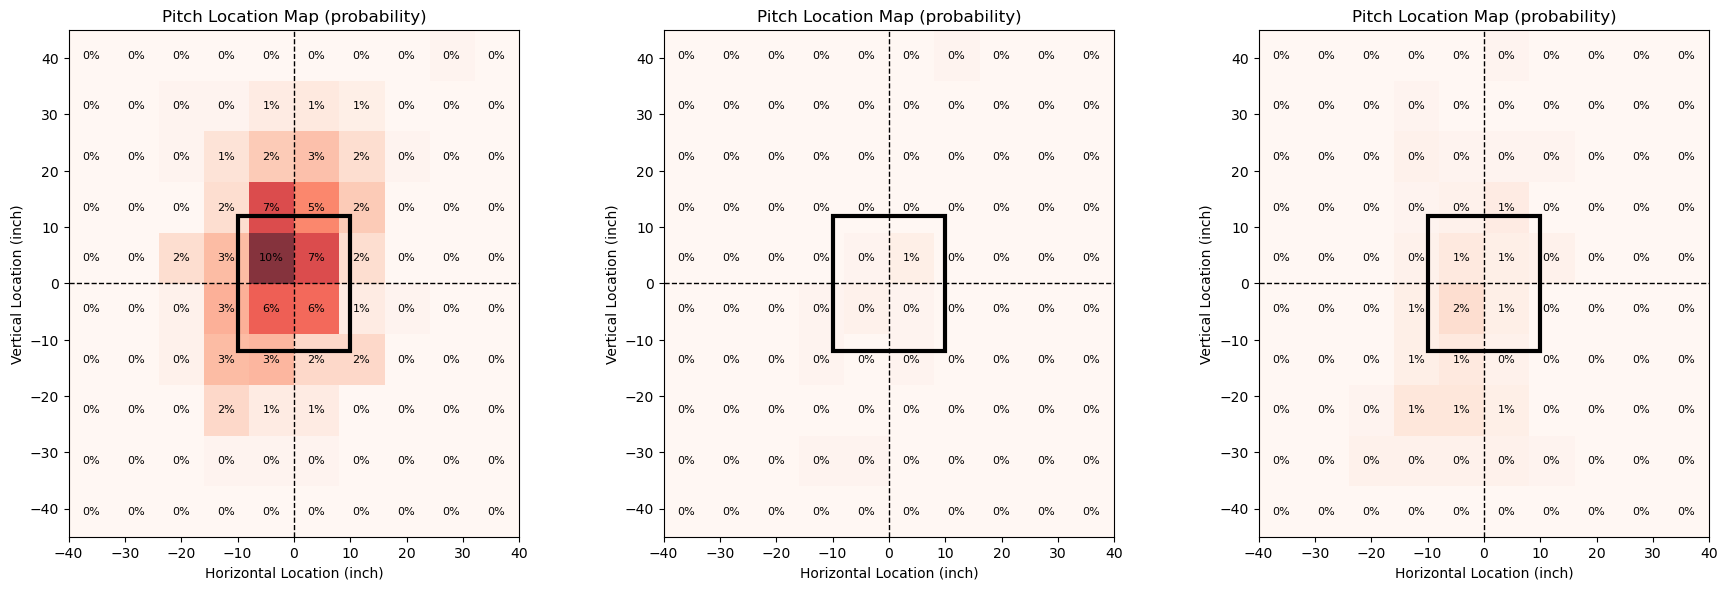

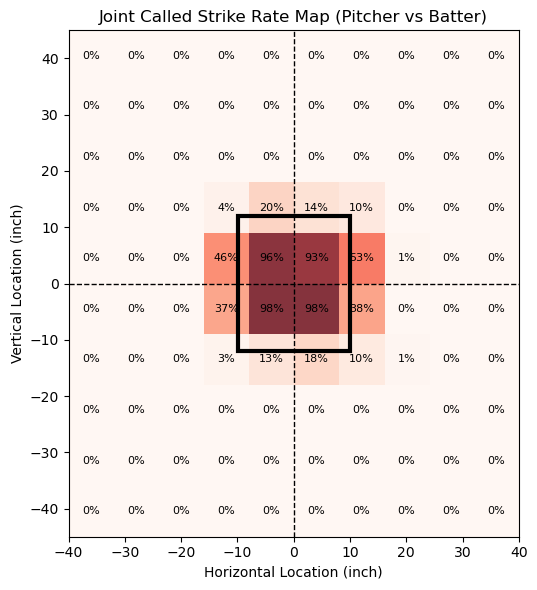

Joint Swing Rate Map (Pitcher vs Batter)


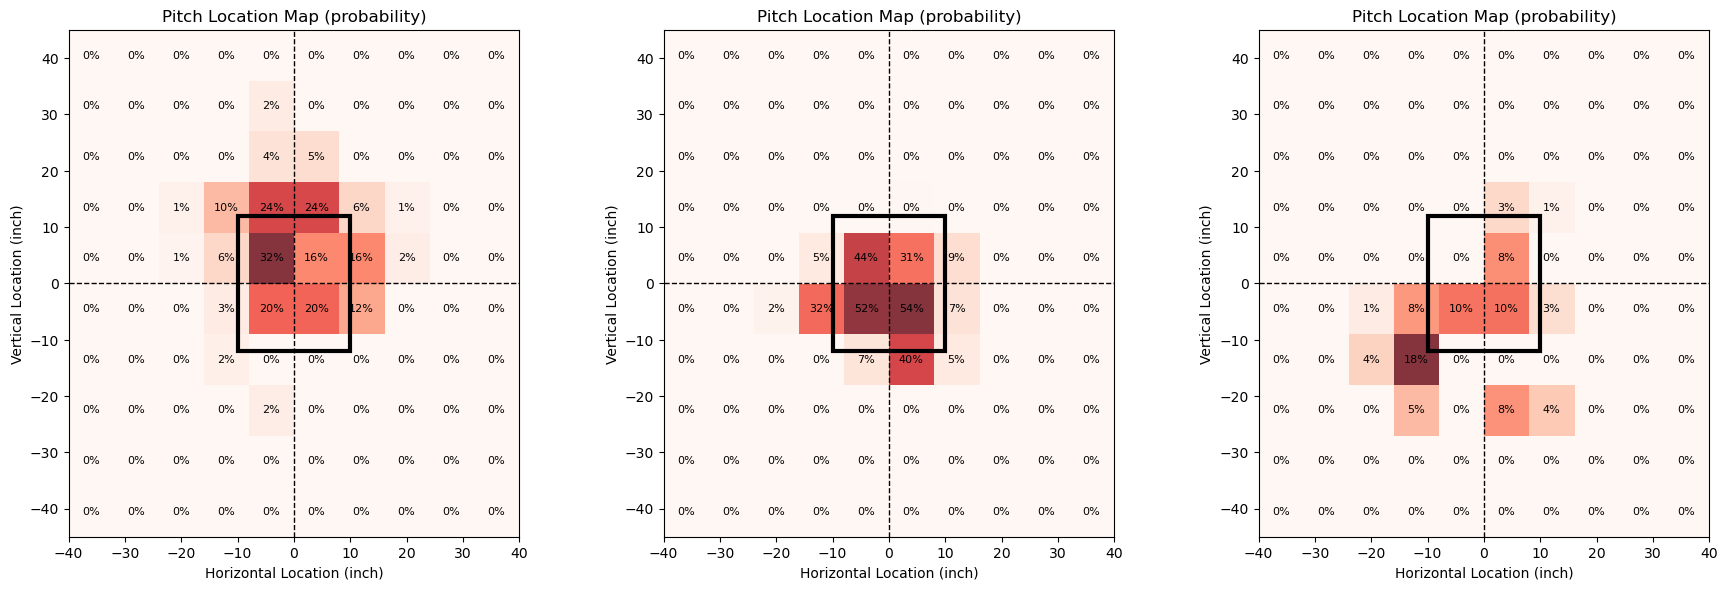

Joint Whiff Rate Map (Pitcher vs Batter)


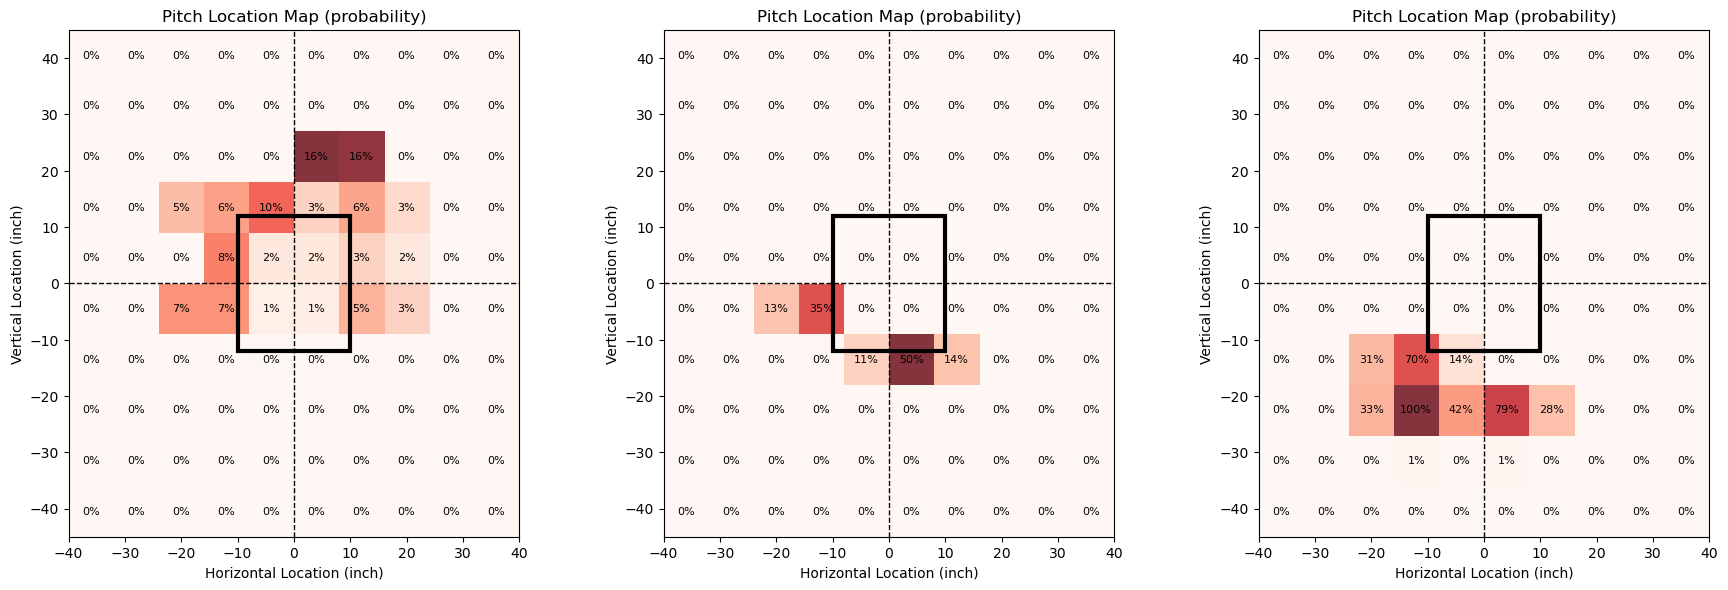

Joint Contact Rate Map (Pitcher vs Batter)


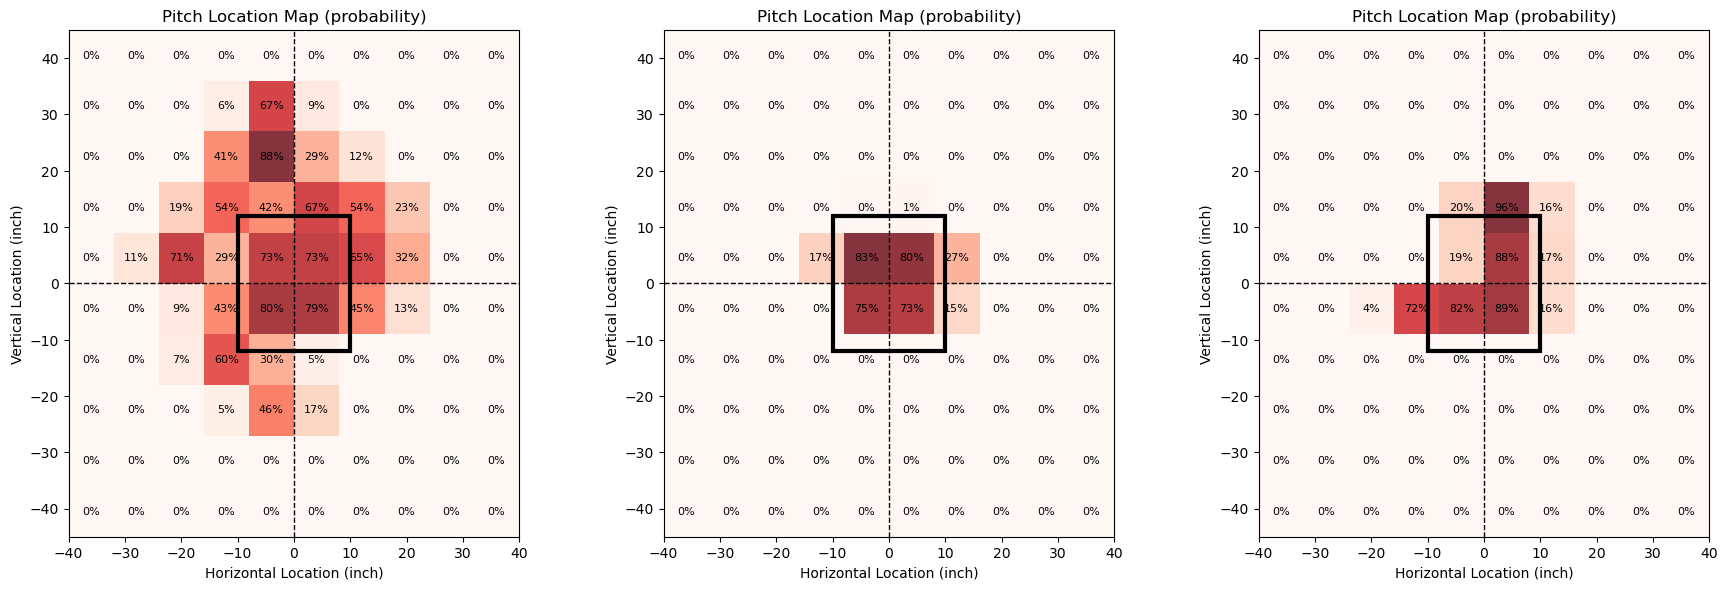

Joint Foul Ball Rate Map (Pitcher vs Batter)


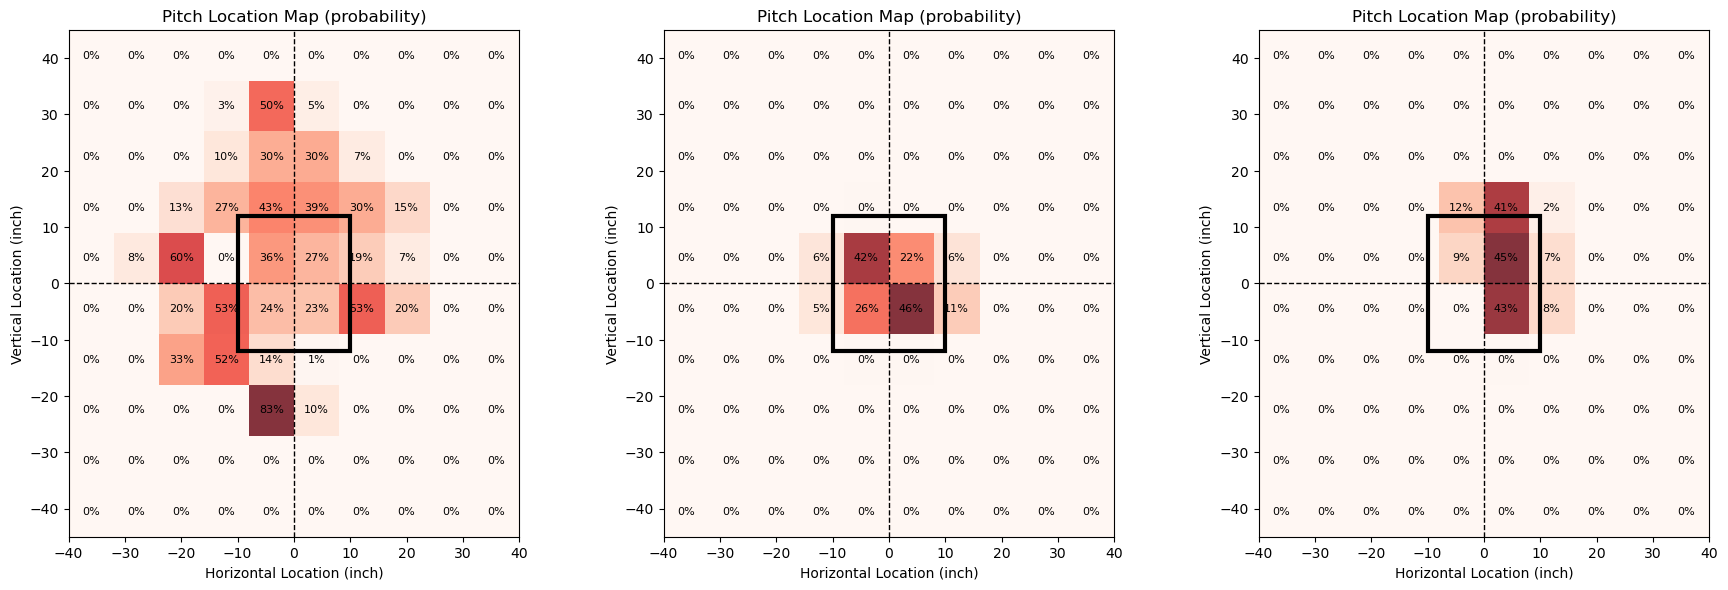

Joint In-Play Rate Map (Pitcher vs Batter)


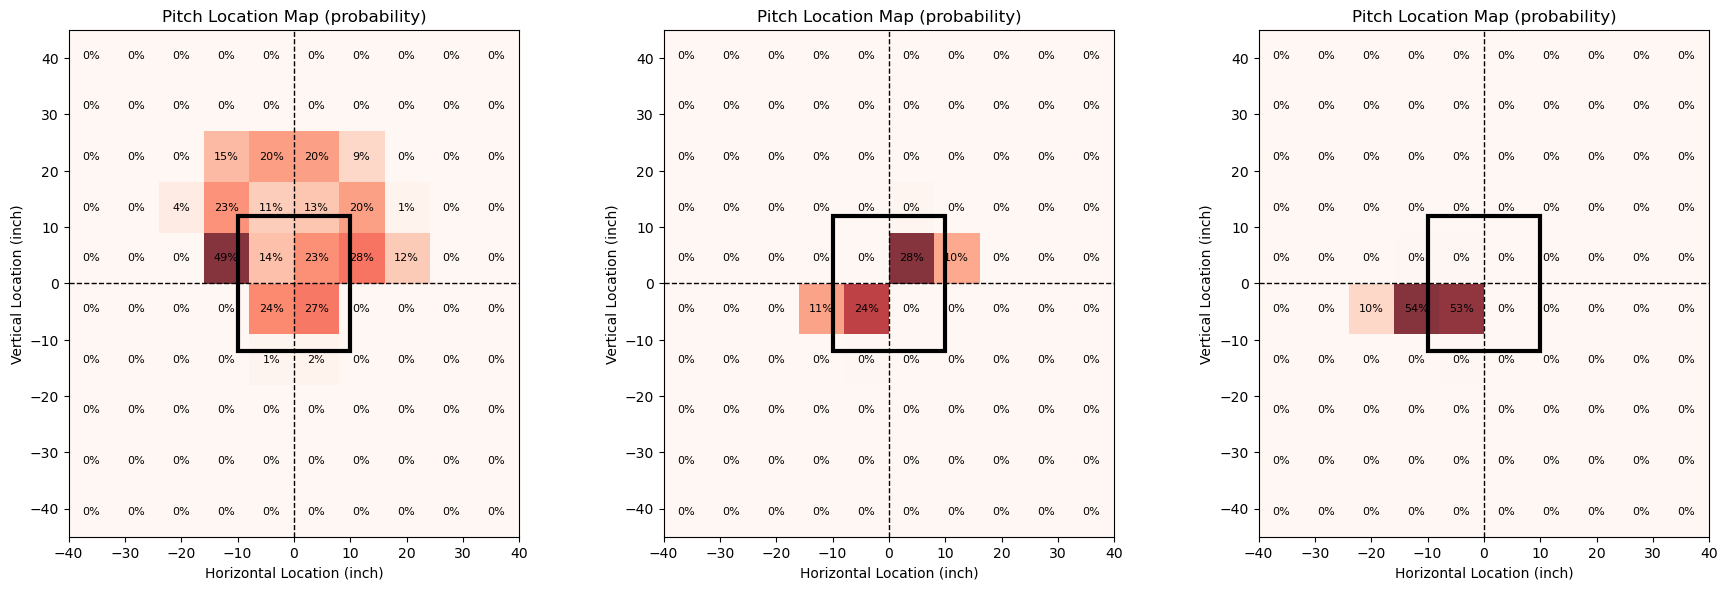

Joint Soft Contact Rate (Pitcher vs Batter)


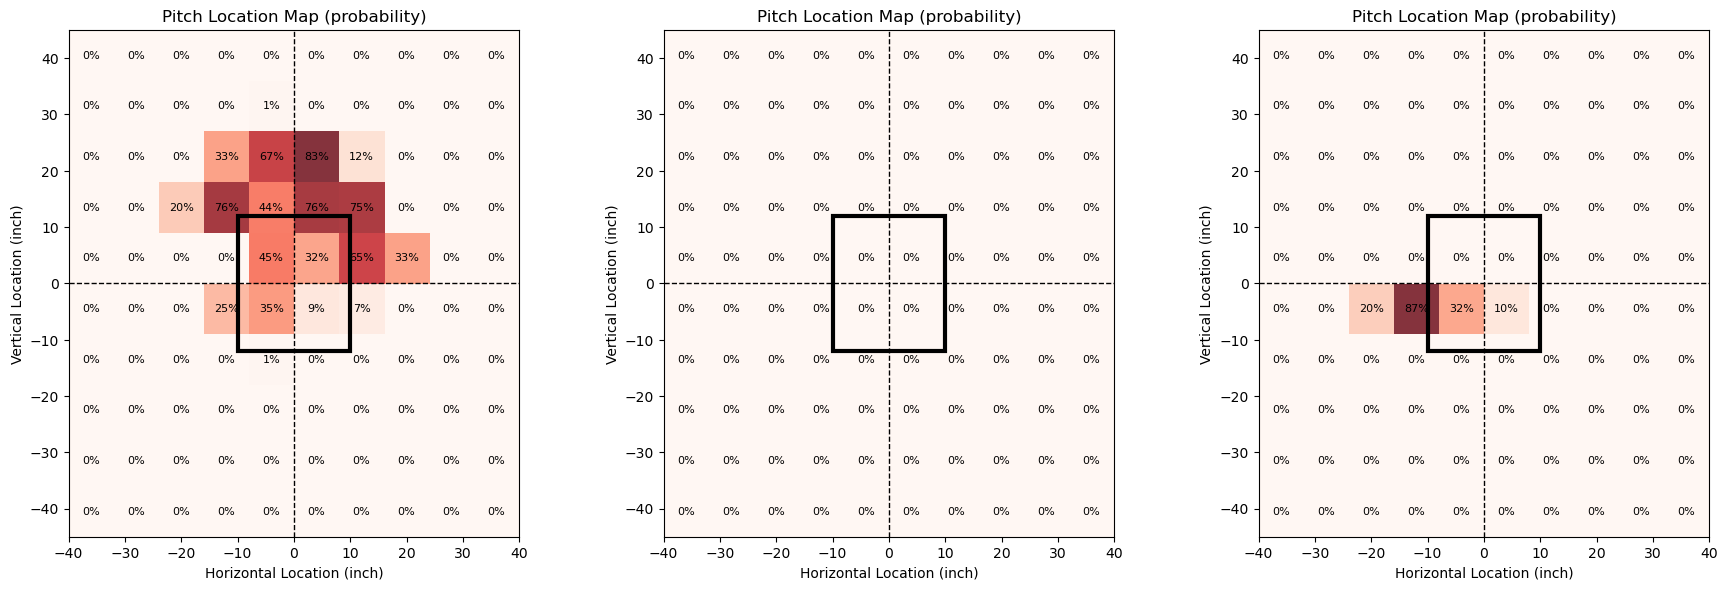

In [38]:
print("Pitch Type Probability Map (Pitcher)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], pitchType_prob_p[:, :, i], type='probability', vmin=0, vmax=np.max(pitchType_prob_p))
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6,6), tight_layout=True)
single_map(ax, called_strike_rate, type='probability')
plt.title('Joint Called Strike Rate Map (Pitcher vs Batter)')
plt.show()

print("Joint Swing Rate Map (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], swing_rate[:, :, i], type='probability')
plt.show()

print("Joint Whiff Rate Map (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], whiff_rate[:, :, i], type='probability')
plt.show()


print("Joint Contact Rate Map (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], contact_rate[:, :, i], type='probability')
plt.show()

print("Joint Foul Ball Rate Map (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], foul_rate[:, :, i], type='probability')
plt.show()

print("Joint In-Play Rate Map (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], inplay_rate[:, :, i], type='probability')
plt.show()


print("Joint Soft Contact Rate (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], soft_rate[:, :, i], type='probability')
plt.show()



In [39]:
def one_progress(pitcher, batter, strike=0, ball=0):
    """
    Selects the optimal pitch based on maximizing good outcomes and simulates the result of that single pitch.
    """
    # Get all the necessary probability maps for the current count
    called_strike_rate, swing_rate, whiff_rate, contact_rate, foul_rate, inplay_rate, soft_rate, pitchType_prob_p, pitchType_count_p = pitcher_vs_batter(pitcher, batter, strike, ball)

    # --- Pitch Selection Logic ---
    # Calculate the probability of a "good" outcome for the pitcher for each pitch type and location.
    # Good outcomes: called strike, swinging strike, or soft contact.
    
    # Prob of a called strike (no swing, and it's a strike)
    # called_strike_rate is (bins, bins), needs to be broadcast to (bins, bins, 3) for element-wise multiplication
    prob_called_strike = (1 - swing_rate) * called_strike_rate[:, :, np.newaxis]
    
    # Prob of a swinging strike (whiff)
    prob_swinging_strike = swing_rate * whiff_rate
    
    # Prob of inducing soft contact: P(swing) * P(contact|swing) * P(in-play|contact) * P(soft|in-play)
    prob_soft_contact = swing_rate * contact_rate * inplay_rate * soft_rate
    
    # Total probability of a good outcome for any given pitch
    prob_good_outcome = prob_called_strike + prob_swinging_strike + prob_soft_contact
    
    # Weight the good outcome probability by the pitcher's tendency to throw that pitch to that location
    weighted_prob = prob_good_outcome * pitchType_prob_p
    
    # Flatten the 3D probability map to a 1D array to sample from it
    prob_flat = weighted_prob.flatten()
    
    # Normalize the probabilities to sum to 1 for sampling
    if np.sum(prob_flat) > 0:
        prob_flat /= np.sum(prob_flat)
        # Probabilistically choose a pitch based on the weighted good outcome probabilities
        chosen_pitch_flat_idx = np.random.choice(len(prob_flat), p=prob_flat)
    else:
        # Fallback: if all probabilities are zero, just pick the one with the highest (zero) probability
        chosen_pitch_flat_idx = np.argmax(weighted_prob)

    # Convert the flat index back to 3D indices (y, x, pitch_type)
    y_idx, x_idx, pitch_type_idx = np.unravel_index(chosen_pitch_flat_idx, weighted_prob.shape)
    
    pitch_types_list = ['Fastball', 'Offspeed', 'Breaking']
    print(f"Chosen Pitch: {pitch_types_list[pitch_type_idx]} at ({x_centers[x_idx]:.1f}, {y_centers[y_idx]:.1f})")
    
    # --- Outcome Simulation Logic ---
    # Simulate the outcome of the chosen pitch
    p_swing = swing_rate[y_idx, x_idx, pitch_type_idx]
    
    # Use a random number to determine if the batter swings
    if np.random.rand() > p_swing: # No Swing
        p_called_strike = called_strike_rate[y_idx, x_idx]
        if np.random.rand() < p_called_strike:
            strike += 1
            print("Outcome: Called Strike")
        else:
            ball += 1
            print("Outcome: Ball")
    else: # Swing
        p_whiff = whiff_rate[y_idx, x_idx, pitch_type_idx]
        if np.random.rand() < p_whiff:
            strike += 1
            print("Outcome: Swinging Strike (Whiff)")
        else: # Contact
            p_foul = foul_rate[y_idx, x_idx, pitch_type_idx]
            if np.random.rand() < p_foul:
                if strike < 2:
                    strike += 1
                print("Outcome: Foul Ball")
            else: # In Play
                p_soft = soft_rate[y_idx, x_idx, pitch_type_idx]
                if np.random.rand() < p_soft:
                    print("Outcome: In Play, Soft Contact (Out)")
                else:
                    print("Outcome: In Play, Hard Contact (Hit)")
                # End of Plate Appearance
                return None, None

    # Check for end of PA due to count
    if strike >= 3:
        print("Outcome: Strikeout")
        return None, None
    if ball >= 4:
        print("Outcome: Walk")
        return None, None

    print(f"New Count: {ball} Balls, {strike} Strikes")
    return ball, strike
# Simulate one pitch starting from a 0-0 count


def one_pa(pitcher, batter):
    current_ball, current_strike = one_progress(pitcher, batter, strike=0, ball=0)
    for i in range(20):
        if current_ball is None or current_strike is None:
            break
        current_ball, current_strike = one_progress(pitcher, batter, strike=current_strike, ball=current_ball)


In [40]:
from joblib import Parallel, delayed
import tqdm
import numpy as np

def one_progress_sim(pitcher, batter, strike=0, ball=0):
    """
    Selects an optimal pitch and simulates the outcome, returning detailed results.
    """
    # Get probability maps for the current count
    called_strike_rate, swing_rate, whiff_rate, contact_rate, foul_rate, inplay_rate, soft_rate, pitchType_prob_p, _ = pitcher_vs_batter(pitcher, batter, strike, ball)

    # --- Pitch Selection ---
    prob_called_strike = (1 - swing_rate) * called_strike_rate[:, :, np.newaxis]
    prob_swinging_strike = swing_rate * whiff_rate
    prob_soft_contact = swing_rate * contact_rate * inplay_rate * soft_rate
    prob_good_outcome = prob_called_strike + prob_swinging_strike + prob_soft_contact
    weighted_prob = prob_good_outcome * pitchType_prob_p
    
    prob_flat = weighted_prob.flatten()
    if np.sum(prob_flat) > 0:
        prob_flat /= np.sum(prob_flat)
        chosen_pitch_flat_idx = np.random.choice(len(prob_flat), p=prob_flat)
    else:
        # If all probabilities are zero, fall back to the maximum weighted probability
        # This can happen if the pitcher has no history for a certain count
        chosen_pitch_flat_idx = np.argmax(weighted_prob)

    y_idx, x_idx, pitch_type_idx = np.unravel_index(chosen_pitch_flat_idx, weighted_prob.shape)
    
    pitch_types_list = ['Fastball', 'Offspeed', 'Breaking']
    chosen_pitch = {
        "type": pitch_types_list[pitch_type_idx],
        "location": (f"{x_centers[x_idx]:.1f}", f"{y_centers[y_idx]:.1f}")
    }

    # --- Outcome Simulation ---
    outcome = None
    p_swing = swing_rate[y_idx, x_idx, pitch_type_idx]
    
    if np.random.rand() > p_swing: # No Swing
        p_called_strike = called_strike_rate[y_idx, x_idx]
        if np.random.rand() < p_called_strike:
            strike += 1
            outcome = "Called Strike"
        else:
            ball += 1
            outcome = "Ball"
    else: # Swing
        p_whiff = whiff_rate[y_idx, x_idx, pitch_type_idx]
        if np.random.rand() < p_whiff:
            strike += 1
            outcome = "Swinging Strike"
        else: # Contact
            p_foul = foul_rate[y_idx, x_idx, pitch_type_idx]
            if np.random.rand() < p_foul:
                if strike < 2:
                    strike += 1
                outcome = "Foul"
            else: # In Play
                p_soft = soft_rate[y_idx, x_idx, pitch_type_idx]
                if np.random.rand() < p_soft:
                    outcome = "Out"
                else:
                    outcome = "Hit"
                # For 'Out' or 'Hit', the PA ends immediately.
                return ball, strike, chosen_pitch, outcome

    if strike >= 3:
        outcome = "Strikeout"
    if ball >= 4:
        outcome = "Walk"
    
    
    return ball, strike, chosen_pitch, outcome

def run_one_pa_simulation(pitcher, batter):
    """
    Simulates a single plate appearance from start to finish.
    This function is designed to be called in parallel.
    """
    current_ball, current_strike = 0, 0
    sequence = []
    final_outcome = None
    
    # Max pitches in a PA to prevent infinite loops
    for _ in range(20):
        start_count = (current_ball, current_strike)
        current_ball, current_strike, pitch, outcome = one_progress_sim(pitcher, batter, strike=current_strike, ball=current_ball)
        
        sequence.append({
            "count": f"{start_count[1]}-{start_count[0]}", # Standard Strike-Ball format
            "pitch": pitch,
            "outcome": outcome
        })
        
        if outcome in ["Strikeout", "Walk", "Hit", "Out"]:
            final_outcome = outcome
            break
    
    # If the loop finishes without a definitive outcome, assign one based on the count
    if final_outcome is None:
        if current_strike >= 3:
            final_outcome = "Strikeout"
        elif current_ball >= 4:
            final_outcome = "Walk"
        else:
            # Fallback for rare cases where loop ends without resolution
            final_outcome = "In-Progress"

    # Only return a result if the plate appearance had 3 or more pitches
    if len(sequence) >= 3:
        return {"sequence": sequence, "final_outcome": final_outcome, "pitches": len(sequence)}
    else:
        try:
            return run_one_pa_simulation(pitcher, batter)  # Retry the PA simulation
        except Exception as e:
            print(f"Error occurred: {e}")
            return None

def simulate_multiple_pas(num_pas, pitcher, batter):
    """
    Simulates a specified number of plate appearances in parallel.
    """
    # Use joblib to run simulations in parallel with a progress bar
    # n_jobs=-1 uses all available CPU cores
    results = Parallel(n_jobs=-1)(
        delayed(run_one_pa_simulation)(pitcher, batter) for _ in tqdm.tqdm(range(num_pas), desc="Simulating PAs")
    )
    return results

def analyze_sequences(completed_pas):
    """
    Analyzes the simulated PAs to find common sequences for good and bad outcomes.
    """
    good_outcomes = ["Strikeout", "Out"]
    bad_outcomes = ["Walk", "Hit"]
    
    good_sequences = {}
    bad_sequences = {}

    # Filter out None results before processing
    valid_pas = [pa for pa in completed_pas if pa is not None]

    for pa in valid_pas:
        # Create a tuple of (pitch_type, location, outcome) to use as a dictionary key
        detailed_sequence = tuple(
            f"{p['pitch']['type']}({p['pitch']['location'][0]},{p['pitch']['location'][1]})-{p['outcome']}" for p in pa['sequence']
        )
        
        if pa['final_outcome'] in good_outcomes:
            good_sequences[detailed_sequence] = good_sequences.get(detailed_sequence, 0) + 1
        elif pa['final_outcome'] in bad_outcomes:
            bad_sequences[detailed_sequence] = bad_sequences.get(detailed_sequence, 0) + 1
            
    # Sort by frequency
    sorted_good = sorted(good_sequences.items(), key=lambda item: item[1], reverse=True)
    sorted_bad = sorted(bad_sequences.items(), key=lambda item: item[1], reverse=True)
    
    return sorted_good, sorted_bad


In [41]:

# --- Main Execution ---
NUM_SIMULATIONS = 1000
# The user must have defined 'pitcher' and 'batter' DataFrames in a previous cell.
# The function 'pitcher_vs_batter' and variables like 'x_centers', 'y_centers' must also be defined.
completed_pas = simulate_multiple_pas(NUM_SIMULATIONS, pitcher, batter)
good_sequences, bad_sequences = analyze_sequences(completed_pas)


Simulating PAs: 100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]


In [42]:

print("\n--- Top 5 Good Sequences (for Pitcher) ---")
for seq, count in good_sequences[:10]:
    print(f"Count: {count} ({count/NUM_SIMULATIONS*100:.1f}%) | Sequence: {' -> '.join(seq)}")

print("\n--- Top 5 Bad Sequences (for Pitcher) ---")
for seq, count in bad_sequences[:10]:
    print(f"Count: {count} ({count/NUM_SIMULATIONS*100:.1f}%) | Sequence: {' -> '.join(seq)}")


--- Top 5 Good Sequences (for Pitcher) ---
Count: 4 (0.4%) | Sequence: Fastball(4.0,-4.5)-Called Strike -> Fastball(-4.0,-4.5)-Called Strike -> Breaking(-4.0,-4.5)-Strikeout
Count: 3 (0.3%) | Sequence: Fastball(4.0,4.5)-Called Strike -> Fastball(-4.0,-4.5)-Called Strike -> Fastball(-12.0,4.5)-Out
Count: 2 (0.2%) | Sequence: Breaking(-4.0,-4.5)-Called Strike -> Breaking(4.0,4.5)-Called Strike -> Breaking(-4.0,-4.5)-Strikeout
Count: 2 (0.2%) | Sequence: Fastball(-4.0,4.5)-Called Strike -> Offspeed(4.0,4.5)-Foul -> Fastball(-12.0,4.5)-Out
Count: 2 (0.2%) | Sequence: Fastball(4.0,-4.5)-Called Strike -> Fastball(-4.0,-4.5)-Called Strike -> Fastball(-4.0,-4.5)-Out
Count: 2 (0.2%) | Sequence: Fastball(-4.0,-4.5)-Called Strike -> Fastball(-4.0,-4.5)-Foul -> Breaking(-12.0,-4.5)-Out
Count: 2 (0.2%) | Sequence: Fastball(4.0,-4.5)-Called Strike -> Fastball(-4.0,-4.5)-Called Strike -> Fastball(4.0,13.5)-Out
Count: 2 (0.2%) | Sequence: Fastball(4.0,4.5)-Called Strike -> Offspeed(4.0,4.5)-Foul -> B